In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Bootstrap Tutorial

This notebook contains a tutorial on how to use the bootstrap functionality provided by estimagic. We start with the simplest possible example of calculating standard errors and confidence intervals for an OLS estimator without and clustering. Then we progress to more advanced examples.

In this example, we will work with the "exercise" example dataset taken from the seaborn library.

The working example will be a linear regression to investigate the effects of exercise time on pulse.

## Prepare the dataset

In [2]:
df = sns.load_dataset("exercise", index_col=0)
replacements = {"1 min": 1, "15 min": 15, "30 min": 30}
df = df.replace({"time": replacements})
df["constant"] = 1

df.head()

,id,diet,pulse,time,kind,constant
0,1,low fat,85,1,rest,1
1,1,low fat,85,15,rest,1
2,1,low fat,88,30,rest,1
3,2,low fat,90,1,rest,1
4,2,low fat,92,15,rest,1


## Doing a very simple bootstrap

The first thing we need is a function that calculates the bootstrap outcome, given an empirical or re-sampled dataset. The bootstrap outcome is the quantity for which you want to calculate standard errors and confidence intervals. In most applications those are just parameter estimates.

In our case, we want to regress "pulse" on "time" and a constant, and the function looks as follows:

In [3]:
def ols_fit(data):

    y = data["pulse"]
    x = data[["constant", "time"]]
    params = sm.OLS(y, x).fit().params
    return params

The outcome function must return a pandas Series.

Now we wan calculated confidence intervals and standard errors.

In [4]:
from estimagic.inference import bootstrap

results_without_cluster = bootstrap(data=df, outcome=ols_fit)
results_without_cluster

,mean,std,lower_ci,upper_ci
constant,93.815998,1.566557,90.806508,97.014317
time,0.376655,0.127959,0.147757,0.647338


The above function call represents the minimum that a user has to specify, making full use of the default options, such as drawing a 1000 bootstrap draws, using the "percentile" bootstrap confidence interval, not making use of parallelization, etc.

If we would for example want to make 10000 draws, while parallelizing on two cores and using a "bca" type confidence interval, we would simply call the following.

In [5]:
results_without_cluster2 = bootstrap(
    data=df, outcome=ols_fit, n_draws=10_000, ci_method="bca", n_cores=2
)

results_without_cluster2

,mean,std,lower_ci,upper_ci
constant,93.79045,1.557405,91.757155,97.354431
time,0.38619,0.126238,0.120206,0.557303


## Doing a clustered bootstrap

In the cluster robust variant of the bootstrap, the original dataset is divided into clusters according to the values of some user-specified variable, and then clusters are drawn uniformly with replacement in order to create the different bootstrap samples. 

In order to use the cluster robust boostrap, we simply specify which variable to cluster by. In the example we are working with, it seems sensible to cluster on individuals, i.e. on the column "id" of our dataset.

In [6]:
results_with_cluster = bootstrap(data=df, outcome=ols_fit, cluster_by="id")

results_with_cluster

,mean,std,lower_ci,upper_ci
constant,93.729417,1.188667,91.360832,96.070291
time,0.380310,0.101324,0.194380,0.584603


We can see that the estimated standard errors are indeed of a smaller magnitude when we use the cluster robust bootstrap. 

Finally, we can compare the results to full sample regressions using the statsmodels regression function and see that the cluster robust bootstrap gives standard error estimates very close to the cluster robust regression, while the regular bootstrap seems to overestimate the standard errors of both coefficients.

Note: We would not expect the asymptotic statsmodels standard errors to be exactly the same as the bootstrapped standard errors.


In [7]:
y = df["pulse"]
x = df[["constant", "time"]]


cluster_robust_ols = sm.OLS(y, x).fit(cov_type="cluster", cov_kwds={"groups": df["id"]})

cluster_robust_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pulse   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     13.75
Date:                Fri, 02 Jul 2021   Prob (F-statistic):           0.000879
Time:                        11:35:16   Log-Likelihood:                -365.51
No. Observations:                  90   AIC:                             735.0
Df Residuals:                      88   BIC:                             740.0
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant      93.7611      1.205     77.837      0.000      91.400      96.122
time           0.3873      0.104      3.708      0.000       0.183       0.592
==============================================================================
Omnibus:                       20.828   Durbin-Watson:                   0.827
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.313
Skew:                           1.173   Prob(JB):                     1.93e-06
Kurtosis:                       4.231   Cond. No.                         31.7
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

## Splitting up the process

In many situations the above examples are enough. However, sometimes it is important to split up the bootstrapping process into smaller steps. Examples for such situations are:

- You want to look at the bootstrap estimates
- You want to do a bootstrap with a low number of draws first and add more draws later without duplicated calculations
- You have more bootstrap outcomes than just the parameters

### Calculating bootsrap outcomes

In [8]:
from estimagic.inference import get_bootstrap_outcomes

my_outcomes = get_bootstrap_outcomes(data=df, outcome=ols_fit, seed=1234)
my_outcomes.head()

,constant,time
0,92.377004,0.465963
1,94.549027,0.219700
2,94.171886,0.298749
3,94.087851,0.346593
4,93.624816,0.466219


To further compare the cluster bootstrap to the uniform bootstrap, let's plot the sampling distribution of the parameters on time. We can again see that the standard error is smaller when we cluster on the subject id. 

<AxesSubplot:xlabel='time', ylabel='Density'>

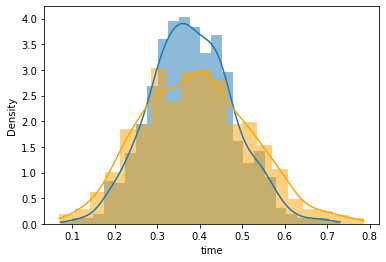

In [9]:
my_outcomes_clustered = get_bootstrap_outcomes(
    data=df, outcome=ols_fit, seed=1234, cluster_by="id"
)

# clustered distribution in blue
sns.histplot(my_outcomes_clustered["time"], kde=True, stat="density", linewidth=0)

# non-clustered distribution in orange
sns.histplot(my_outcomes["time"], kde=True, stat="density", linewidth=0, color="orange")

### Calculating standard errors and confidence intervals from existing outcomes

Once we have the outcomes, we can compute confidence intervals and standard errors from them

In [10]:
from estimagic.inference import bootstrap_from_outcomes

my_results = bootstrap_from_outcomes(
    data=df, outcome=ols_fit, bootstrap_outcomes=my_outcomes, ci_method="t"
)
my_results

,mean,std,lower_ci,upper_ci
constant,93.767044,1.501594,90.756341,96.598375
time,0.391806,0.128111,0.113098,0.617271


You can use this to calculate confidence intervals with several methods (e.g. "bca" and "percentile") without duplicated calculations.

## Extending bootstrap results with more draws

It is often the case that for speed reasons you set the number of bootstrap draws quite low, so you can look at results earlier and later decide that you need more draws. 

In the long run, we will offer a Dashboard integration for this. For now, you can do it manually.

As an example we will take `my_outcomes` defined above and extend it with another 500 draws. 

Note: It is very important to use a different random seed when you calculate the additional outcomes!!!

In [11]:
more_outcomes = get_bootstrap_outcomes(data=df, outcome=ols_fit, seed=5471, n_draws=500)
combined_outcomes = pd.concat([my_outcomes, more_outcomes])
combined_results = bootstrap_from_outcomes(
    data=df,
    outcome=ols_fit,
    bootstrap_outcomes=combined_outcomes,
)

## More than one outcome

to be written

## Accessing the bootstrap samples

It is also possible to just access the bootstrap samples. You can use this for example, if you want to calculate your the bootstrap outcomes in parallel in a way that is not yet supported by estimagic (e.g. on a large cluster or supercomputer).

In [12]:
from estimagic.inference import get_bootstrap_samples

my_samples = get_bootstrap_samples(data=df, seed=1234)

my_samples[0]

,id,diet,pulse,time,kind,constant
47,16,no fat,89,30,walking,1
83,28,no fat,140,30,running,1
38,13,low fat,93,30,walking,1
53,18,no fat,101,30,walking,1
76,26,no fat,126,15,running,1
...,...,...,...,...,...,...
0,1,low fat,85,1,rest,1
33,12,low fat,93,1,walking,1
21,8,no fat,92,1,rest,1
71,24,low fat,120,30,running,1
